In [1]:
from xgboost import XGBClassifier, plot_importance, plot_tree
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import fbeta_score
from math import radians, cos, sin, asin, sqrt

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
RANDOM_SEED = 27

import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [3]:
data=pd.read_csv("train.csv",index_col="tripid")
features_df=data.drop('label',axis=1)
label_df=data['label'].replace(['correct','incorrect'],[1,0])

In [4]:
def haversine(lon1, lat1, lon2, lat2):
  lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
  # haversine formula 
  dlon = lon2 - lon1 
  dlat = lat2 - lat1 
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * asin(sqrt(a)) 
  r = 6371 # Radius of earth in kilometers. Use 3956 for miles
  return c * r

In [5]:
def update_features(features_df):

    distances = []
    second_per_fare = []
    fare_per_distance = []
    fare_per_second = []

    for row in features_df.itertuples(index=True):
      distances.append(
          haversine(row.drop_lon, row.drop_lat, row.pick_lon, row.pick_lat)
      )

    features_df['distance'] = distances

    for row in features_df.itertuples(index=True):
      if row.fare == 0:
        second_per_fare.append(np.nan)
      else:
        second_per_fare.append(row.duration/row.fare)

      if row.distance == 0:
        fare_per_distance.append(np.nan)
      else:
        fare_per_distance.append(row.fare/row.distance)

      if row.duration == 0:
        fare_per_second.append(np.nan)
      else:
        fare_per_second.append(row.fare/row.duration)


    features_df['fare_per_distance'] = fare_per_distance
    features_df['fare_per_second'] = fare_per_second
    features_df['second_per_fare'] = second_per_fare

    features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'], format='%m/%d/%Y %H:%M')
    features_df['drop_time'] = pd.to_datetime(features_df['drop_time'], format='%m/%d/%Y %H:%M')

    features_df['pickup_time_minutes'] = features_df['pickup_time'].dt.minute
    features_df['pickup_time_hours'] = features_df['pickup_time'].dt.hour

    features_df['drop_time_minutes'] = features_df['drop_time'].dt.minute
    features_df['drop_time_hours'] = features_df['drop_time'].dt.hour
  
    features_df=features_df.drop(['pick_lat', 'pick_lon', 'drop_lat', 'drop_lon','drop_time','pickup_time'], axis=1)

    return features_df

In [6]:
features_df = update_features(features_df)

In [7]:
numeric_cols= features_df.columns[features_df.dtypes != "object"].values

numeric_preprocessing_steps = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='mean')),
    ('standard_scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ]
)

features_df = preprocessor.fit_transform(features_df)

In [8]:
model = XGBClassifier(objective= 'binary:logistic', learning_rate =0.1, n_estimators=4000, max_depth=5,
                         min_child_weight=2, gamma=0.2, subsample=0.6, colsample_bytree=0.8,
                              nthread=4, scale_pos_weight=1,seed=27, reg_lambda = 30)

In [9]:
x_train, x_eval, y_train, y_eval = train_test_split(
    features_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

In [10]:
model.fit(x_train, y_train)

KeyError: 'base_score'

KeyError: 'base_score'

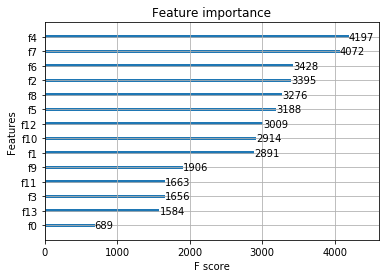

In [11]:
plot_importance(model)
plt.show()

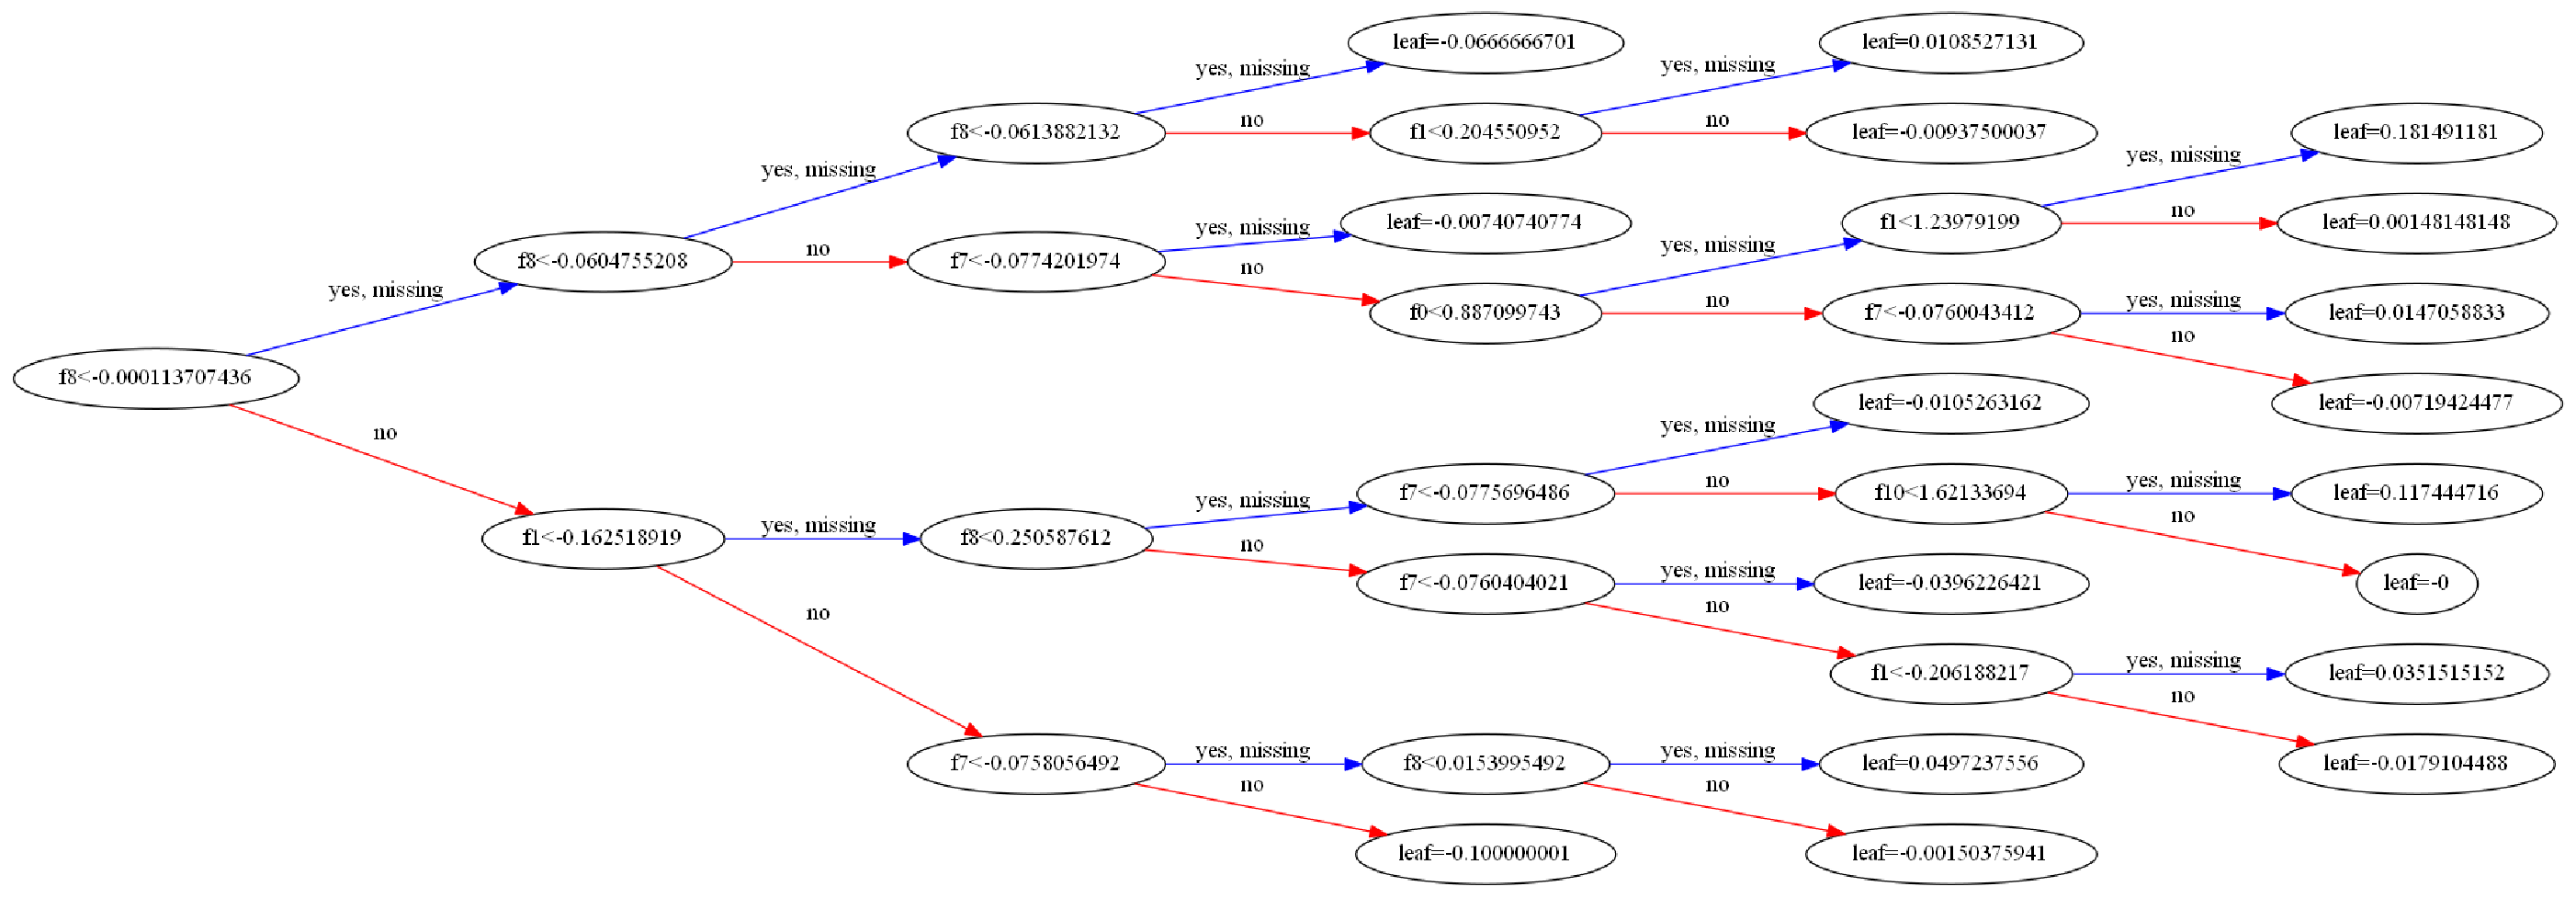

In [12]:
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 50,50

plot_tree(model, num_trees=0, rankdir='LR')
plt.show()

In [13]:
preds = model.predict(x_eval)

In [14]:
y_preds = pd.DataFrame(
    {
        "label": preds
    },
    index = y_eval.index
)

In [15]:
fbeta_score(y_eval, y_preds, average='macro', beta=0.5)

0.8882242207263278

In [16]:
test_features_df = pd.read_csv("test.csv", 
                               index_col="tripid")

In [17]:
test_features_df = update_features(test_features_df)
test_features_df_ = preprocessor.fit_transform(test_features_df)

In [18]:
submission_df = pd.read_csv("sample_submission.csv", 
                            index_col="tripid")

In [19]:
test_probas = model.predict(test_features_df_)

In [20]:
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

submission_df["prediction"] = test_probas

In [21]:
submission_df.to_csv('my_submission.csv', index=True)